In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.config.experimental_run_functions_eagerly(True)

Init Plugin
Init Graph Optimizer
Init Kernel
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [2]:
img_dir = '/Users/adityavs14/Documents/Internship/Pianalytix/Deep_Fake/ML_model/real-vs-fake/'

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
input_shape = (128,128,1)

In [6]:
real = []
fake = []

os.listdir(img_dir)

['valid', '.DS_Store', 'test', 'train']

In [7]:
df = {"image_path":[],"img_status":[],"where":[]}
for where in os.listdir(img_dir):
    if os.path.isdir(img_dir+"/"+where):
        for status in os.listdir(img_dir+"/"+where):
            for image in glob.glob(img_dir+where+"/"+status+"/"+"*.jpg"):
                df["image_path"].append(image)
                df["img_status"].append(status)
                df["where"].append(where)
df = pd.DataFrame(df)
df

,image_path,img_status,where
0,/Users/adityavs14/Documents/Internship/Pianaly...,real,valid
1,/Users/adityavs14/Documents/Internship/Pianaly...,real,valid
2,/Users/adityavs14/Documents/Internship/Pianaly...,real,valid
3,/Users/adityavs14/Documents/Internship/Pianaly...,real,valid
4,/Users/adityavs14/Documents/Internship/Pianaly...,real,valid
...,...,...,...
139995,/Users/adityavs14/Documents/Internship/Pianaly...,fake,train
139996,/Users/adityavs14/Documents/Internship/Pianaly...,fake,train
139997,/Users/adityavs14/Documents/Internship/Pianaly...,fake,train
139998,/Users/adityavs14/Documents/Internship/Pianaly...,fake,train


In [ ]:
df

In [8]:
df.value_counts("img_status")

img_status
fake    70000
real    70000
Name: count, dtype: int64

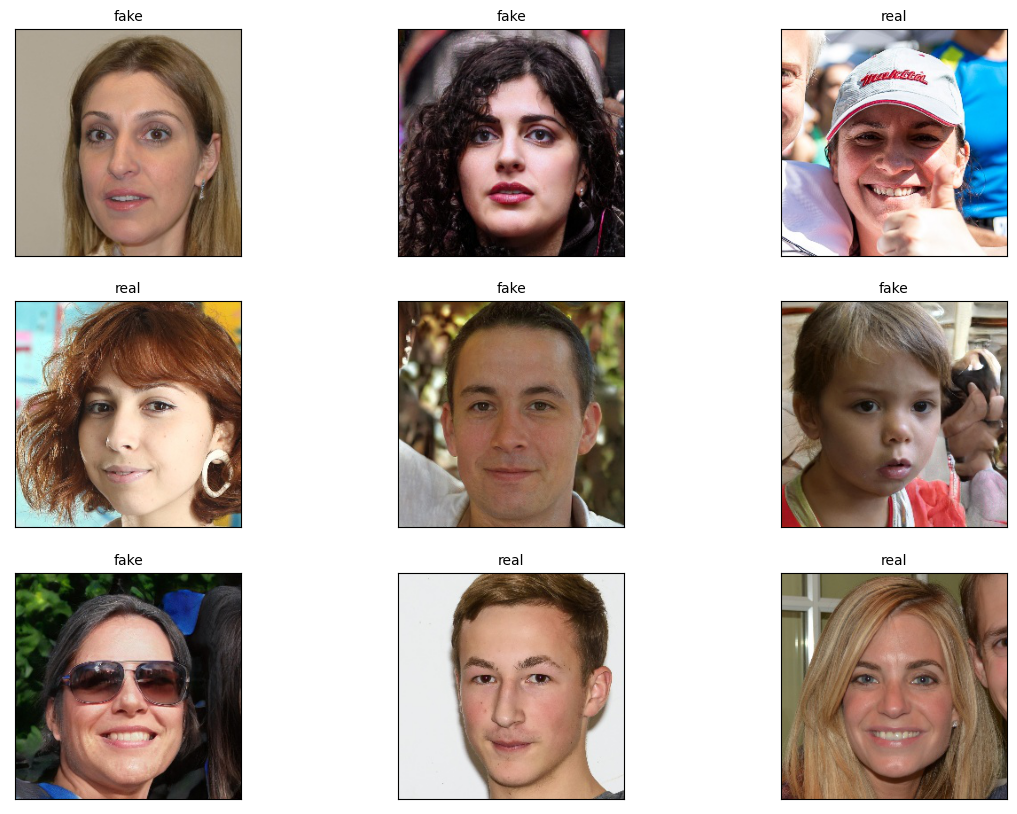

In [9]:
plt.figure(figsize = (14,10))
for i in range(9):
    random = np.random.randint(1,len(df))
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(df.loc[random,"image_path"]))
    plt.title(df.loc[random, "img_status"], size = 10) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [10]:
data_gen = ImageDataGenerator()

In [11]:
train_generator = data_gen.flow_from_directory(
    img_dir + 'train/',
    target_size=(128,128),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [12]:
valid_generator = data_gen.flow_from_directory(
    img_dir + 'valid/',
    target_size=(128,128),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [13]:
test_generator = data_gen.flow_from_directory(
    img_dir + 'test/',
    target_size=(128,128,),
    batch_size=1,
    color_mode='grayscale',
    shuffle = False,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Normal DCNN

In [14]:
import tensorflow
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPool2D, Activation, BatchNormalization

In [15]:
def blockc(y,filt,kern):
    x = tensorflow.keras.layers.Conv2D(filt,kern, padding = 'same')(y)
    x = tensorflow.keras.layers.MaxPool2D(2 , strides = 2, padding = 'same')(x)
    x = tensorflow.keras.layers.BatchNormalization()(x)
    x = tensorflow.keras.layers.Activation('relu')(x)
    
    
    return x

In [16]:
#define model
tensorflow.keras.backend.clear_session()
model = tensorflow.keras.Sequential()


inp = tensorflow.keras.layers.Input((128, 128,1))
c0 = tensorflow.keras.layers.Conv2D(4,3, padding = 'same')(inp)
c0 = tensorflow.keras.layers.MaxPool2D(2)(c0)
c1 = blockc(c0,16,3)
c2 = blockc(c1,32,3)
c3 = blockc(c2,64,3)
c4 = blockc(c3,128,3)
c5 = blockc(c4,64,3)
c6 = blockc(c5,32,3)
c6 =tensorflow.keras.layers.GlobalAveragePooling2D()(c6)
out = tensorflow.keras.layers.Dense(1,activation='sigmoid')(c6)
model = tf.keras.Model(inputs = [inp], outputs = [out])

          
    

Metal device set to: Apple M1


2023-04-25 08:12:09.316826: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-25 08:12:09.317383: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 4)       40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        592       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0     

In [44]:
history = model.fit(
    train_generator,
    steps_per_epoch = (100000//1000),
    validation_data = valid_generator,
    validation_steps = (20000//1000),
    epochs = 10
)

Epoch 1/10
100/100 [==============================] - 14s 140ms/step - loss: 0.2711 - accuracy: 0.8875 - val_loss: 0.3422 - val_accuracy: 0.8530
Epoch 2/10
100/100 [==============================] - 12s 120ms/step - loss: 0.2473 - accuracy: 0.9001 - val_loss: 0.4355 - val_accuracy: 0.8025
Epoch 3/10
100/100 [==============================] - 12s 120ms/step - loss: 0.2407 - accuracy: 0.9013 - val_loss: 0.5720 - val_accuracy: 0.7620
Epoch 4/10
100/100 [==============================] - 12s 122ms/step - loss: 0.2279 - accuracy: 0.9068 - val_loss: 0.3289 - val_accuracy: 0.8720
Epoch 5/10
100/100 [==============================] - 12s 121ms/step - loss: 0.2142 - accuracy: 0.9123 - val_loss: 0.4061 - val_accuracy: 0.8320
Epoch 6/10
100/100 [==============================] - 12s 121ms/step - loss: 0.2081 - accuracy: 0.9156 - val_loss: 0.3609 - val_accuracy: 0.8380
Epoch 7/10
100/100 [==============================] - 12s 120ms/step - loss: 0.2030 - accuracy: 0.9216 - val_loss: 0.3272 - val_ac

# Testing

In [45]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

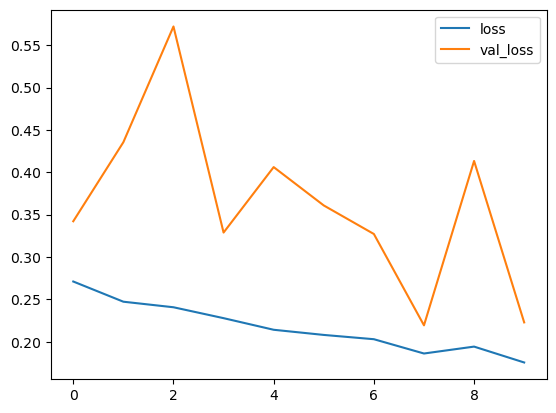

In [46]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

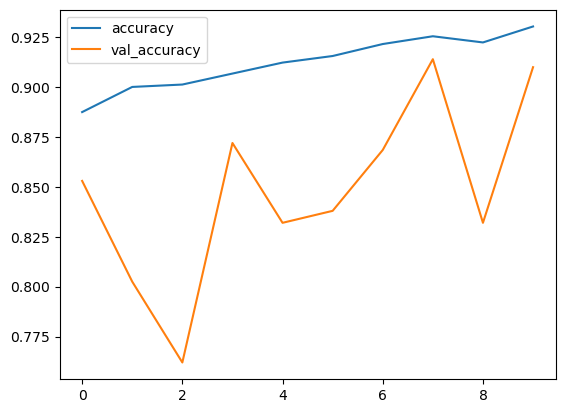

In [47]:
losses[['accuracy','val_accuracy']].plot()

In [50]:
y_pred = model.predict(test_generator,verbose=1)
y_test = test_generator.classes

20000/20000 [==============================] - 99s 5ms/step


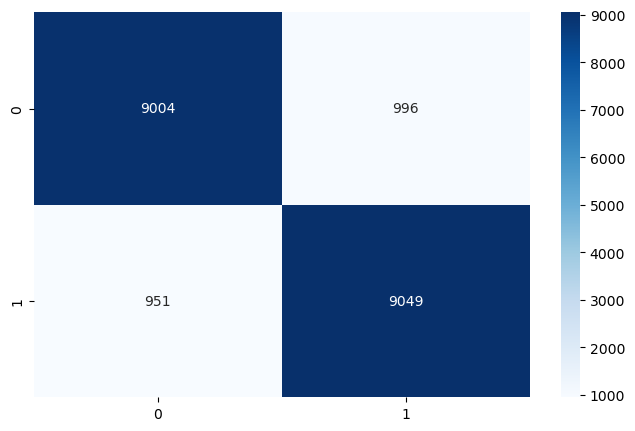

In [51]:
from sklearn import metrics
plt.figure(figsize = (8,5))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred.round()), annot = True,fmt="d",cmap = "Blues")
plt.show()

In [52]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

ROC-AUC Score: 0.966183155
AP Score: 0.964583348018401


In [53]:
print(metrics.classification_report(y_test, y_pred > 0.5))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     10000
           1       0.90      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [54]:
import cv2

In [57]:
for i in range(12441,12451):
    img = cv2.imread(df.iloc[i][0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(128, 128))
    img = np.array(img)
    img = img.reshape((-1,128,128,1))
    pred = np.round(model.predict(img))
    if pred == 0:
        status = "Fake"
    else:
        status = "Real"
    print(i)
    print("Predicted Status: ",status)
    print("Actual status: ",df.iloc[i][1])
    print("\n\n---------------------------\n\n")
    

12441
Predicted Status:  Fake
Actual status:  fake


---------------------------


12442
Predicted Status:  Fake
Actual status:  fake


---------------------------


12443
Predicted Status:  Fake
Actual status:  fake


---------------------------


12444
Predicted Status:  Fake
Actual status:  fake


---------------------------


12445
Predicted Status:  Fake
Actual status:  fake


---------------------------


12446
Predicted Status:  Fake
Actual status:  fake


---------------------------


12447
Predicted Status:  Fake
Actual status:  fake


---------------------------


12448
Predicted Status:  Fake
Actual status:  fake


---------------------------


12449
Predicted Status:  Fake
Actual status:  fake


---------------------------


12450
Predicted Status:  Real
Actual status:  fake


---------------------------




In [58]:
model.save('deepfake.h5')